## DMIPY VERDICT fitting

Firstly, I import all the compartments: sphere, ball and stick, and set up the model.

In [2]:
from dmipy.signal_models import sphere_models, cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel, MultiCompartmentSphericalHarmonicsModel


sphere = sphere_models.S4SphereGaussianPhaseApproximation(diffusion_constant=1.2e-9)
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()

from dmipy.core.modeling_framework import MultiCompartmentModel
verdict_mod = MultiCompartmentModel(models=[sphere, ball, stick])
verdict_mod_SH = MultiCompartmentSphericalHarmonicsModel(models=[sphere,ball,stick])

C1 Stick 1 Lambda par has some optimization bounds, and the Ball diffusion is set to 2e-9. 

In [3]:
verdict_mod.set_fixed_parameter('G1Ball_1_lambda_iso', 2e-9)
verdict_mod.set_parameter_optimization_bounds('C1Stick_1_lambda_par', [3.05e-9, 10e-9])
verdict_mod.

OrderedDict([('S4SphereGaussianPhaseApproximation_1_diameter', 1),
             ('C1Stick_1_mu', 2),
             ('C1Stick_1_lambda_par', 1),
             ('partial_volume_0', 1),
             ('partial_volume_1', 1),
             ('partial_volume_2', 1)])

# Setting up an acquisition scheme

In [4]:
from dmipy.core.acquisition_scheme import acquisition_scheme_from_schemefile
from os.path import join


acquisition_path_GS55 = "/Users/theavage/Documents/Master/Data/GS55 - long acquisition"
acquisition_path_GS35 = "/Users/theavage/Documents/Master/Data/GS35"
GS55 = "GS55_long_protocol_2.scheme"
GS35 = "Verdict_brain_5shell_mag2.scheme"

scheme = acquisition_scheme_from_schemefile(join(acquisition_path_GS35, GS35))
scheme.print_acquisition_info

Acquisition scheme summary

total number of measurements: 20
number of b0 measurements: 5
number of DWI shells: 5

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms]
0           |1         |0               |0                        |4.715999999999999|23.484    |50.0 
1           |3         |88              |50                       |4.715999999999999|23.484    |50.0 
2           |1         |0               |0                        |12.212     |31.272000000000002|65.0 
3           |3         |499             |41                       |12.212     |31.272000000000002|65.0 
4           |1         |0               |0                        |16.448     |32.072    |73.4 
5           |3         |2004            |62                       |16.448     |32.072    |73.4 
6           |1         |0               |0                        |24.764000000000003|43.736    |90.1 
7           |3         |3000            |43                       |24.76400000000

Now: Get the data

In [6]:
import dipy
data = dipy.data.fetcher.load_nifti_data(join(acquisition_path_GS55,"GS55_all.nii.gz"))
mask = dipy.data.fetcher.load_nifti_data(join(acquisition_path_GS35,"P35_mask.nii"))

Now, fit the model. 

In [210]:
verdict_fit = verdict_mod.fit(scheme, test_voxels, solver='mix', use_parallel_processing=False)
verdict_fit_mask.fitted_parameters

Setup MIX optimizer in 0.0016062259674072266 seconds
Fitting of 1 voxels complete in 2.8153610229492188 seconds.
Average of 2.8153610229492188 seconds per voxel.


# Visualization

Visualizing the fitted parameters 

In [ ]:
fitted_parameters = verdict_fit_mask.fitted_parameters

fig, axs = plt.subplots(2, 4, figsize=[15, 10])
axs = axs.ravel()

counter=0

xlim = (150,180)
ylim = (100,135)
plt.setp(axs, xlim=xlim, ylim=ylim)

for name, values in fitted_parameters.items():

    if values.squeeze().ndim == 4:
        cf1=axs[counter].imshow(values.squeeze()[:,:,175,0].T,interpolation='nearest')
        axs[counter].set_title(name+" 1")
        fig.colorbar(cf1, ax=axs[counter], shrink=0.5)
        counter += 1

        cf2=axs[counter].imshow(values.squeeze()[:,:,175,1].T,interpolation='nearest')
        axs[counter].set_title(name+" 2")
        fig.colorbar(cf2, ax=axs[counter], shrink=0.5)

        counter += 1
    else:
        cf = axs[counter].imshow(values.squeeze()[:,:,175].T,interpolation='nearest')
        axs[counter].set_title(name)
        fig.colorbar(cf, ax=axs[counter],shrink=0.5)
        counter += 1

cf = axs[counter].imshow(mask.squeeze()[:,:,175].T,interpolation='nearest')
axs[counter].set_title('Tumor mask')


fig.suptitle('Fitted parameters in slice z=175 for tumor',fontsize=30)


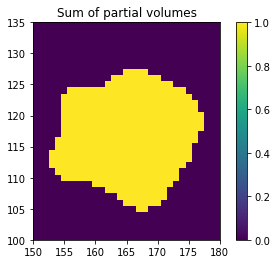

In [170]:
slice = (175,115,175)
sum=0
tot_sum=0

volumes = [fitted_parameters['partial_volume_0'],fitted_parameters['partial_volume_1'],fitted_parameters['partial_volume_2']]

for volume in volumes:
    sum+=volume[slice]

tot = fitted_parameters['partial_volume_0']+fitted_parameters['partial_volume_1']+fitted_parameters['partial_volume_2']

image = plt.imshow(tot[:,:,175].T,interpolation ='nearest')
plt.colorbar(image)
plt.xlim(150,180)
plt.ylim(100,135)
plt.title('Sum of partial volumes')
plt.show()



# Example
To plot a slice

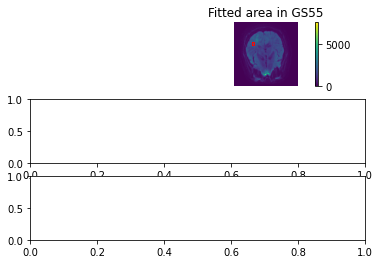

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

fig, ax = plt.subplots(3)
image = ax[0].imshow(data[:, :, 5, 5].T)
fig.colorbar(image,ax=ax[0])
rect = patches.Rectangle((70,80),10,10,linewidth=1,edgecolor='r',facecolor='none')
ax[0].add_patch(rect)
ax[0].set_axis_off()
ax[0].set_title('Fitted area shown in GS55');

E = ax[1].imshow(E[:, :, 0].T)
fig.colorbar(image,ax=ax[1])
ax[1].set_title('Simulated signal');

voxels = ax[2].imshow(test_voxels[:, :, 0].T)
fig.colorbar(image,ax=ax[2])
ax[2].set_title('Actual signal');